# 08 SEI Degradation Model

In this notebook an SEI EC Reaction driven degradation model is created in a similar fashion to Changing a model notebook example using a sim_func. This notebook demonstrates the ageing of cells in a battery pack.

In [14]:
try:
    import liionpack as lp
except:
    !pip install -q git+https://github.com/pybamm-team/liionpack.git@main
    import liionpack as lp
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import textwrap

A 4-parallel 1-series (4p1s) pack is defined.

In [2]:
I_mag = 30.0
OCV_init = 4.0  # used for intial guess
Ri_init = 5e-2  # used for intial guess
R_busbar = 1.5e-3
R_connection = 1e-2
Np = 4
Ns = 1
Nbatt = Np * Ns

Let's create a netlist

In [3]:
netlist = lp.setup_circuit(Np=Np, Ns=Ns, Rb=R_busbar, Rc=R_connection, Ri=Ri_init, V=OCV_init, I=I_mag)

Following experimental protocol with 100 cycles is used for the pack simulation. This will be the applied terminal current for each time step. 

In [4]:
experiment = pybamm.Experiment(
    ["Charge at 15 A for 10 minutes", "Rest for 10 minutes", "Discharge at 15 A for 10 minutes", "Rest for 10 minutes"]*100,
    period="30 seconds",)

Chen2020 parameter set collected for the LG M50 21700 5 Ah cell is used in the simulation.

In [5]:
chemistry = pybamm.parameter_sets.Chen2020
parameter_values = pybamm.ParameterValues(chemistry=chemistry)

Let's pick a variables for the output

In [6]:
output_variables = [  
    'X-averaged total SEI thickness [m]',
    'Loss of capacity to SEI [A.h]',
    ]

Let's define a new sim_func called `SEI_degradation` and pass it to the solver

In [7]:
def SEI_degradation(parameter_values=None):
    """
    Create a PyBaMM simulation set up for integration with liionpack

    Args:
        parameter_values (pybamm.ParameterValues):
            The default is None.

    Returns:
        pybamm.Simulation:
            A simulation that can be solved individually or passed into the
            liionpack solve method

    """
    # Create the pybamm model
    model = pybamm.lithium_ion.SPM(
        options={
            "SEI": "ec reaction limited",
            "SEI film resistance": "distributed",
            "SEI porosity change": "true",
        }
    )

    # Add events to the model
    model = lp.add_events_to_model(model)

    # Set up parameter values
    if parameter_values is None:
        chemistry = pybamm.parameter_sets.Chen2020
        parameter_values = pybamm.ParameterValues(chemistry=chemistry)

    # Set up solver and simulation
    solver = pybamm.CasadiSolver(mode="safe")
    sim = pybamm.Simulation(
        model=model,
        parameter_values=parameter_values,
        solver=solver,
    )

    return sim

In [8]:
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    sim_func=SEI_degradation,
    output_variables=output_variables,
    initial_soc=0.5,
)

Stepping simulation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8001/8001 [00:40<00:00, 195.63it/s]


{'pack': <Figure size 576x432 with 2 Axes>,
 'Cell current [A]': <Figure size 576x432 with 1 Axes>,
 'Cell internal resistance [Ohm]': <Figure size 576x432 with 1 Axes>,
 'Terminal voltage [V]': <Figure size 576x432 with 1 Axes>,
 'Measured battery open circuit voltage [V]': <Figure size 576x432 with 1 Axes>,
 'X-averaged total SEI thickness [m]': <Figure size 576x432 with 1 Axes>,
 'Loss of capacity to SEI [A.h]': <Figure size 576x432 with 1 Axes>}

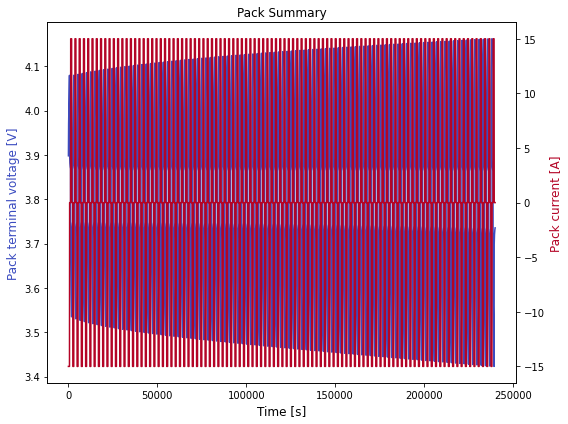

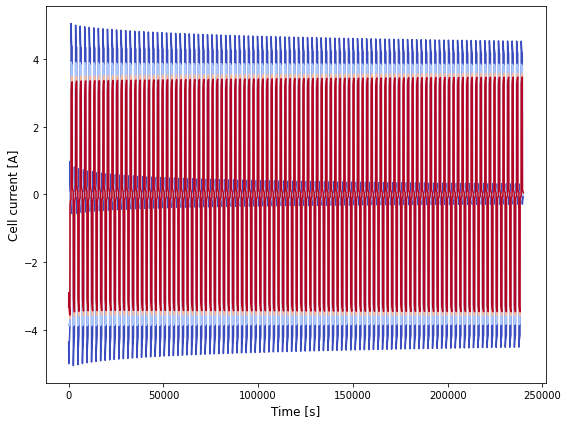

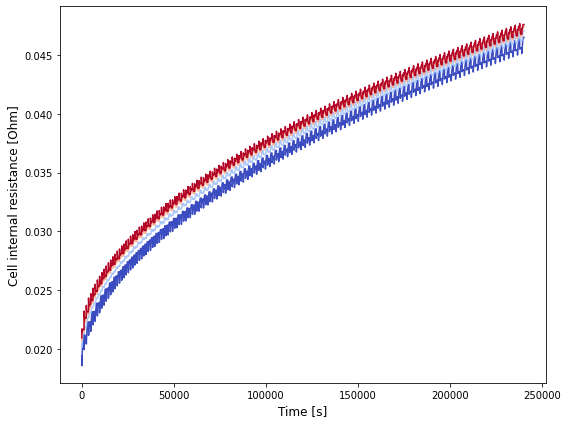

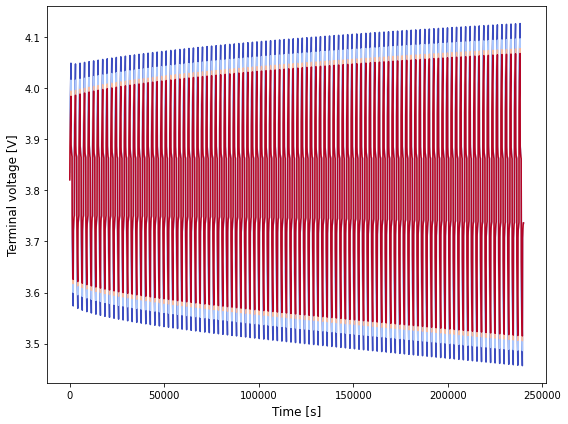

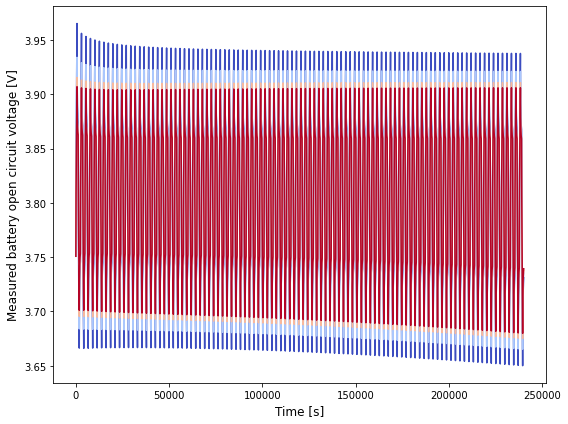

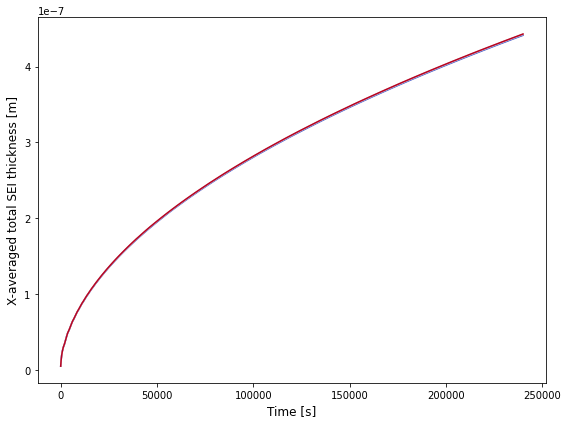

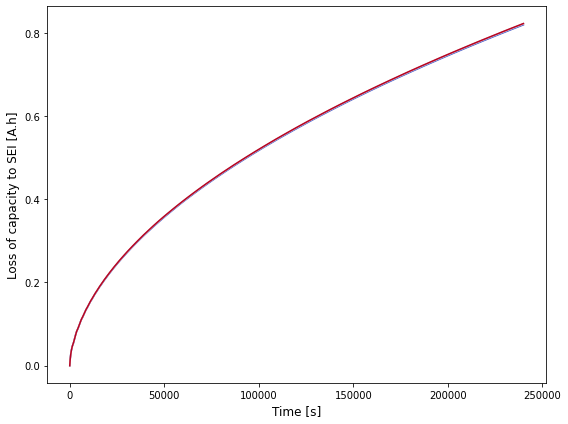

In [9]:
lp.plot_output(output)

We can change the EC initial concentration in electrolyte [mol.m-3] for each cell and see the capacity loss for each cell.

In [10]:
parameter_values.update({"EC initial concentration in electrolyte [mol.m-3]": "[input]"})
EC_conc=np.array([4000.0, 3500.0, 3000.0, 2500.0])
inputs = {"EC initial concentration in electrolyte [mol.m-3]": EC_conc}

In [11]:
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    sim_func=SEI_degradation,
    inputs=inputs,
    output_variables=output_variables,
    initial_soc=0.5
)

Stepping simulation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8001/8001 [00:44<00:00, 181.13it/s]


{'pack': <Figure size 576x432 with 2 Axes>,
 'Cell current [A]': <Figure size 576x432 with 1 Axes>,
 'Cell internal resistance [Ohm]': <Figure size 576x432 with 1 Axes>,
 'Terminal voltage [V]': <Figure size 576x432 with 1 Axes>,
 'Measured battery open circuit voltage [V]': <Figure size 576x432 with 1 Axes>,
 'X-averaged total SEI thickness [m]': <Figure size 576x432 with 1 Axes>,
 'Loss of capacity to SEI [A.h]': <Figure size 576x432 with 1 Axes>}

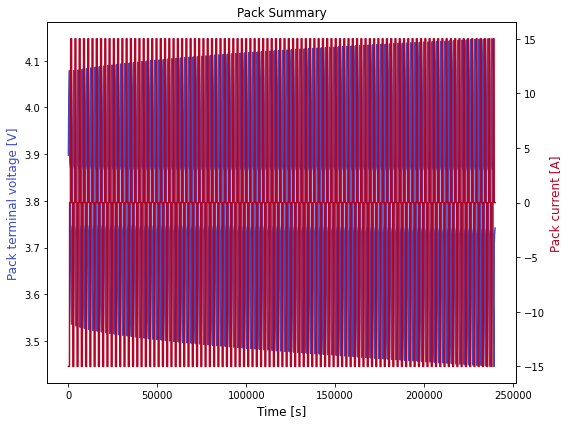

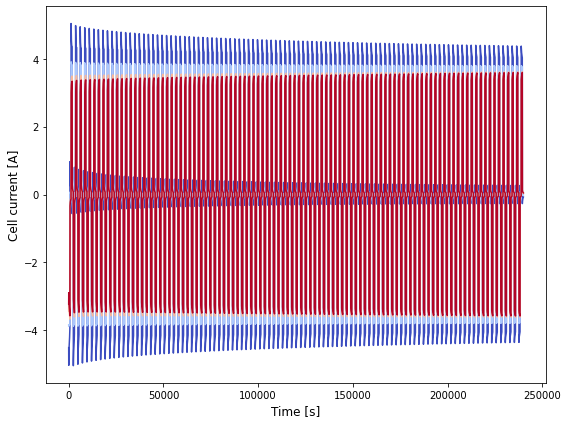

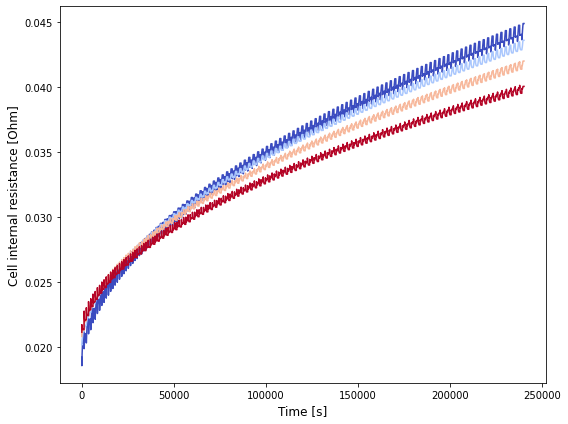

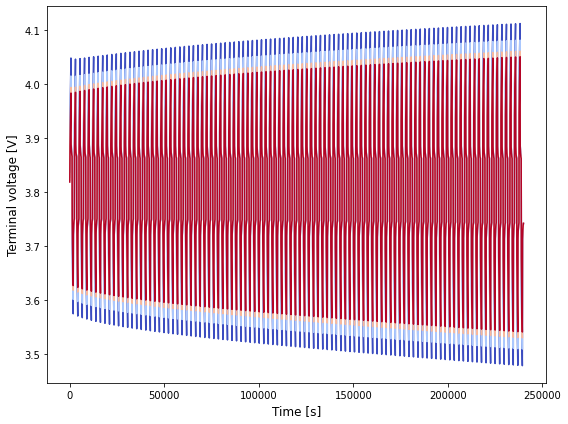

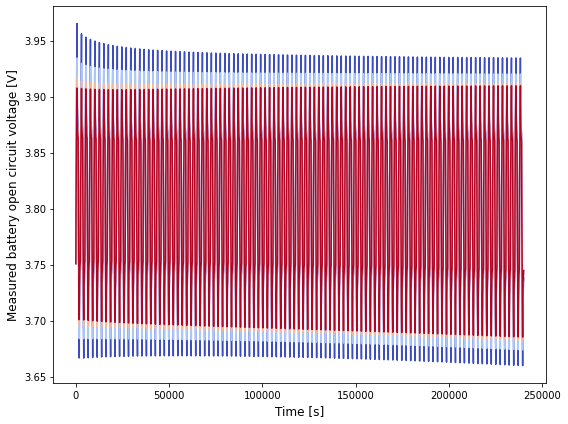

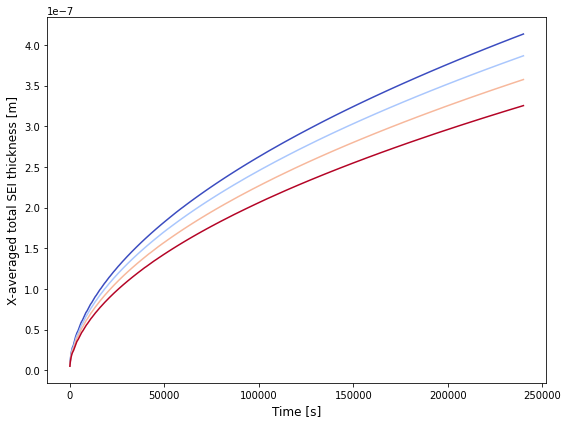

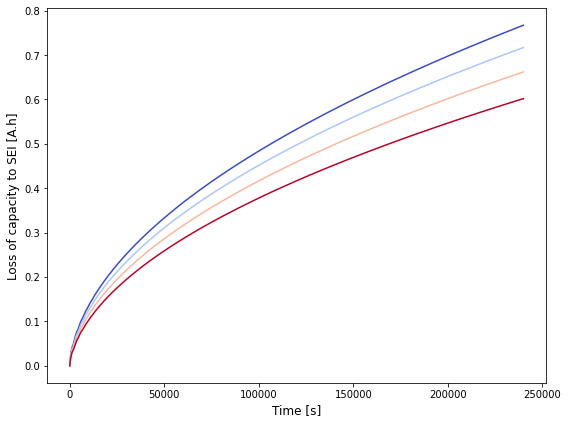

In [12]:
lp.plot_output(output, context="light")

In [20]:
output.keys()

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Cell current [A]', 'Cell internal resistance [Ohm]', 'Terminal voltage [V]', 'Measured battery open circuit voltage [V]', 'X-averaged total SEI thickness [m]', 'Loss of capacity to SEI [A.h]'])

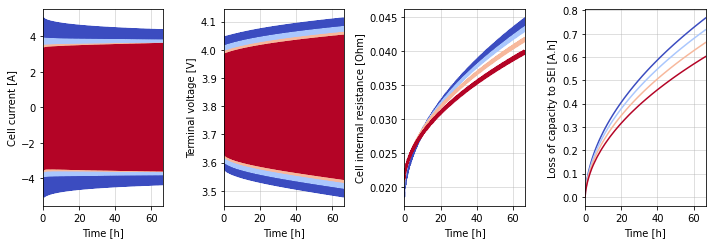

In [23]:

# Get time and results for battery cells
time = output["Time [s]"]/3600
cell_vars = ["Cell current [A]", "Terminal voltage [V]", "Cell internal resistance [Ohm]", "Loss of capacity to SEI [A.h]"]

context = "light"
context = lp.lp_context(context)
cmap = lp.lp_cmap(context)

# Get number of cells and setup colormap
n = output[cell_vars[0]].shape[-1]
colors = cmap(np.linspace(0, 1, n))

# Create plot figures for cell variables
fig, axes = plt.subplots(1,4,figsize=(10,3.5),tight_layout=True,sharex=True)
with plt.rc_context(context):
    for j, var in enumerate(cell_vars):
        ax = axes[j]
        for i in range(n):
            ax.plot(time, output[var][:, i], color=colors[i])
        ax.set_xlabel("Time [h]")
        ax.set_ylabel(textwrap.fill(var, 45))
        ax.ticklabel_format(axis="y", scilimits=[-5, 5])
        ax.set_xlim([0,time[-1]])
        ax.grid(alpha=0.5)
        
    fig.savefig("../figures/degradation.pdf")